<a href="https://colab.research.google.com/github/Jules-gatete/RxMediq_Summative-assignment---MLOP/blob/main/RxMediq_Model_Jules_Gatete_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTING LIBRARIES

In [10]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.compose import ColumnTransformer
import joblib
from google.colab import files

# Set random seed for reproducibility

In [11]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset



In [12]:
# Load dataset
file_path = "/content/drive/MyDrive/Drug prescription Dataset.csv"

df = pd.read_csv(file_path)

DATA PROCESSING



In [13]:
# Display Basic Info
print(df.head())
print(df.info())
print(df.describe())

    disease  age gender severity                drug
0  diarrhea    4   male      LOW  promegranate drink
1  diarrhea    4   male   NORMAL          lime juice
2  diarrhea    5   male      LOW  promegranate drink
3  diarrhea    5   male   NORMAL          lime juice
4  diarrhea    6   male      LOW  promegranate drink
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1288 non-null   object
 1   age       1288 non-null   int64 
 2   gender    1288 non-null   object
 3   severity  1288 non-null   object
 4   drug      1288 non-null   object
dtypes: int64(1), object(4)
memory usage: 50.4+ KB
None
               age
count  1288.000000
mean     33.645963
std      15.532570
min       4.000000
25%      20.000000
50%      34.000000
75%      47.000000
max      60.000000


In [20]:
# Create a copy of the DataFrame to avoid modifying the original
encoded_df = df.copy()

# Label Encoding for categorical features
for column in encoded_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    encoded_df[column] = le.fit_transform(encoded_df[column])

# Compute the correlation matrix
corr_matrix = encoded_df.corr()


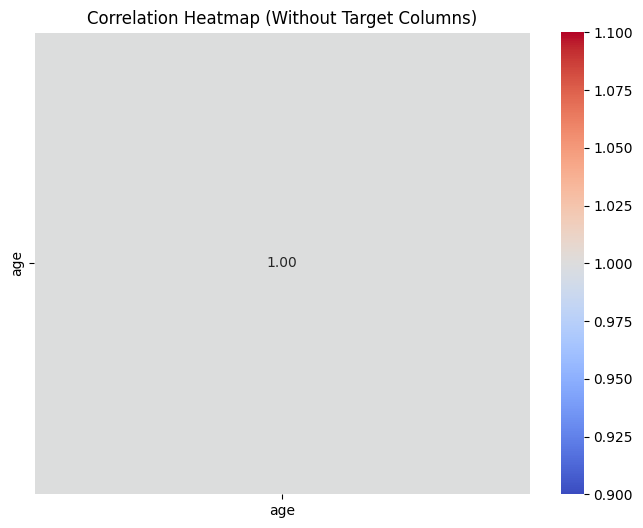

In [21]:
# Compute the correlation matrix
numeric_df = df.select_dtypes(include=np.number)  # Select only numeric columns
corr_matrix = numeric_df.corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Without Target Columns)')
plt.show()

In [22]:
# Check for Missing Values
print("\nMissing Values:\n", df.isnull().sum())




Missing Values:
 disease     0
age         0
gender      0
severity    0
drug        0
dtype: int64


In [8]:
df.describe()

,age
count,1288.000000
mean,33.645963
std,15.532570
min,4.000000
25%,20.000000
50%,34.000000
75%,47.000000
max,60.000000


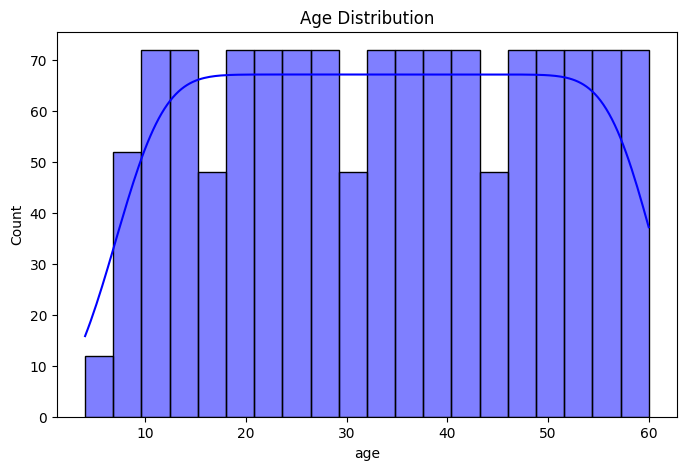

Story: Age distribution highlights patient age range, suggesting age-specific drug trends.


In [9]:
# Visualize Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=20, kde=True, color="blue")
plt.title("Age Distribution")
plt.show()
print("Story: Age distribution highlights patient age range, suggesting age-specific drug trends.")



In [ ]:
# Check for Duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {duplicates}")
df = df.drop_duplicates()

Duplicate Rows: 0


In [ ]:
# Outlier Detection
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]
print(f"Outliers detected in 'age': {len(outliers)}")

Outliers detected in 'age': 0


In [ ]:
# Preprocessing Function (Moved to src/preprocessing.py for deployment)
def preprocess_data(df, label_encoders=None, preprocessor=None, is_new_data=False):
    df = df.dropna().drop_duplicates()
    if label_encoders is None:
        label_encoders = {}
        for col in ["disease", "gender", "severity", "drug"]:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    else:
        for col in ["disease", "gender", "severity", "drug"]:
            df[col] = label_encoders[col].transform(df[col])

    X = df.drop(columns=["drug"])
    y = df["drug"]

    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers=[('num', StandardScaler(), ["age"]), ('cat', "passthrough", X.columns.difference(["age"]))]
        )
        X = preprocessor.fit_transform(X)
    else:
        X = preprocessor.transform(X)

    return X, y, label_encoders, preprocessor

In [ ]:
# Preprocess Data
X, y, label_encoders, preprocessor = preprocess_data(df)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Check for classes with only one sample in y_temp
unique_classes, counts = np.unique(y_temp, return_counts=True)
for cls, count in zip(unique_classes, counts):
    if count < 2:
        print(f"Class {cls} has only {count} sample(s) in y_temp. Consider removing it or increasing the dataset size.")

# If classes with only one sample exist, handle them (e.g., remove or increase dataset size) before proceeding
# ...

# Split into validation and test sets, potentially without stratification if classes with only one sample are removed
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp if np.min(counts) >= 2 else None)

Class 11 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 14 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 15 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 17 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 18 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 19 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 20 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 21 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 22 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 24 has only 1 sample(s) in y_temp. Consider removing it or increasing the dataset size.
Class 26 has only 1 sample(s) in y_temp. Consider removing i

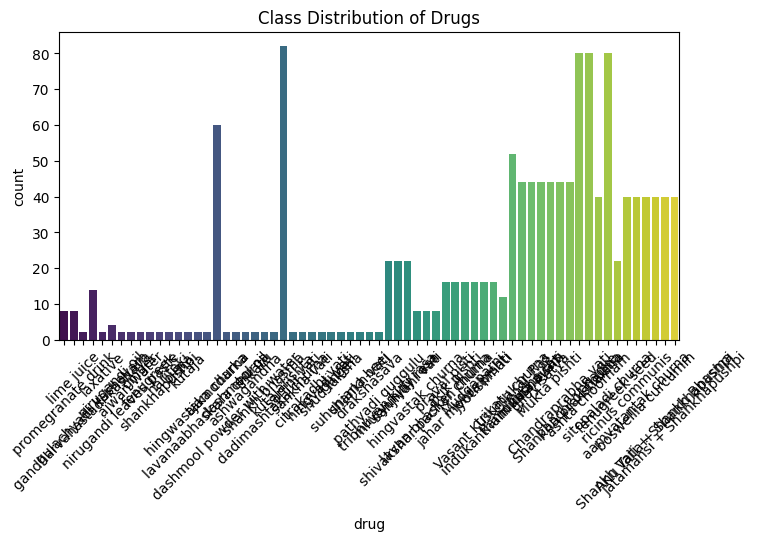

Story: Drug distribution shows prescription frequency, indicating common treatments.


In [ ]:
# Visualize Drug Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=df["drug"], hue=df["drug"], palette="viridis", legend=False)
plt.title("Class Distribution of Drugs")
plt.xticks(rotation=45)
plt.show()
print("Story: Drug distribution shows prescription frequency, indicating common treatments.")

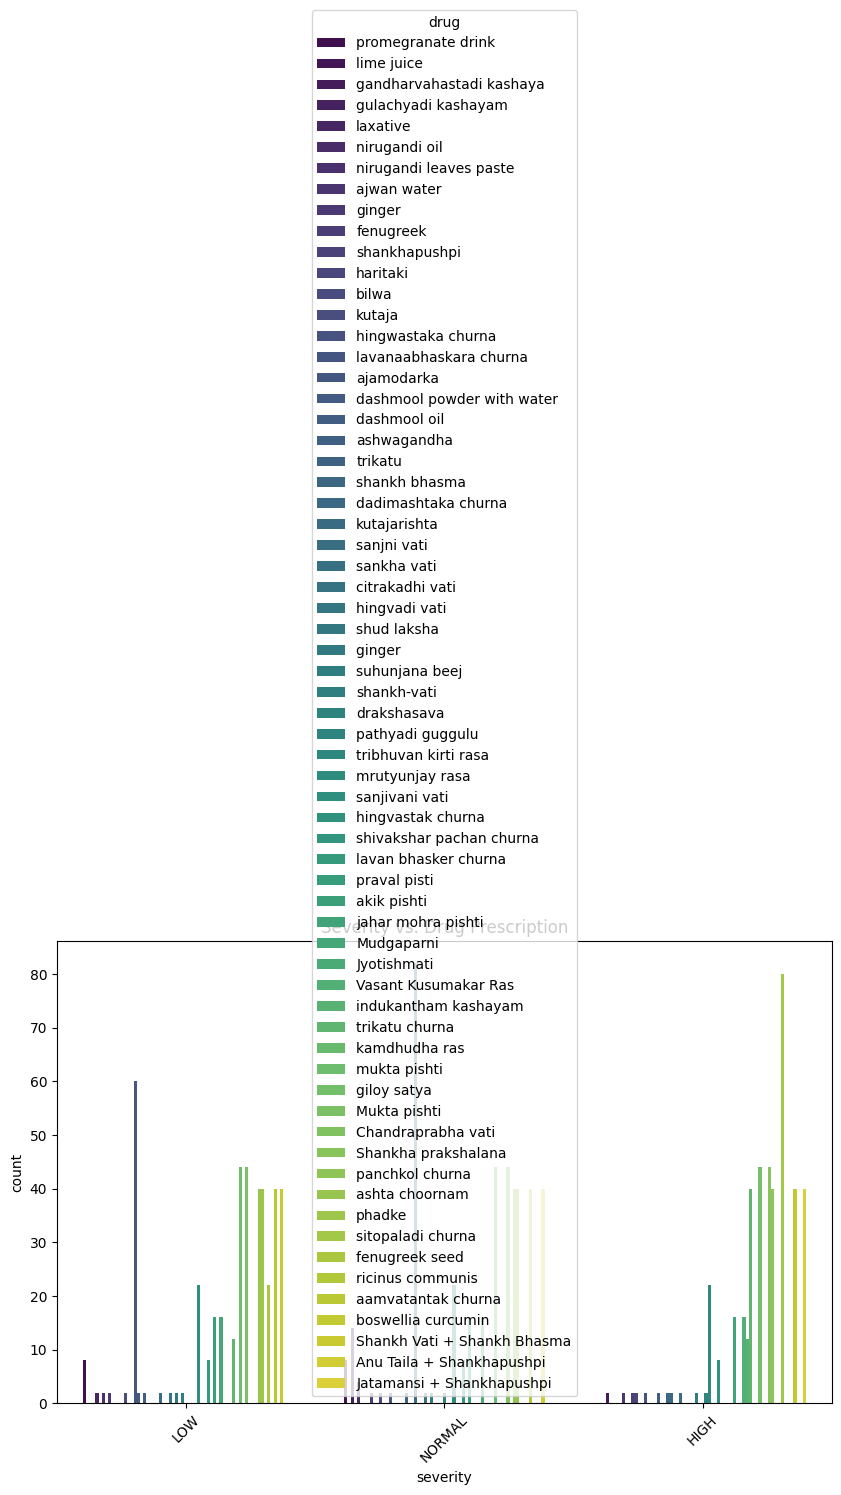

Story: Severity influences drug choice, with distinct preferences per level.


In [ ]:
# Visualize Severity vs. Drug
plt.figure(figsize=(10, 6))
sns.countplot(x="severity", hue="drug", data=df, palette="viridis")
plt.title("Severity vs. Drug Prescription")
plt.xticks(rotation=45)
plt.show()
print("Story: Severity influences drug choice, with distinct preferences per level.")

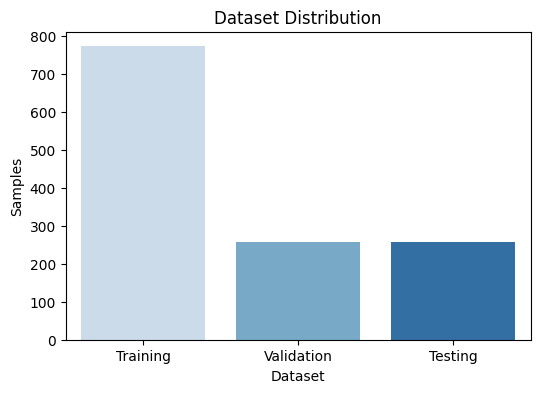

In [ ]:
# Dataset Size Visualization
dataset_sizes = {"Training": X_train.shape[0], "Validation": X_val.shape[0], "Testing": X_test.shape[0]}
df_sizes = pd.DataFrame(dataset_sizes.items(), columns=["Dataset", "Samples"])
plt.figure(figsize=(6, 4))
sns.barplot(x="Dataset", y="Samples", hue="Dataset", data=df_sizes, palette="Blues", dodge=False)
plt.title("Dataset Distribution")
plt.show()

In [ ]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, model_name, history=None):
    loss = model.evaluate(X_test, y_test, verbose=0)[0] if isinstance(model, Sequential) else None
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)

    metrics = {
        "Loss": loss,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"\n📊 Performance Metrics - {model_name}:")
    if loss: print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    if history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"Training History - {model_name}")
        plt.legend()
        plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return metrics

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

📊 Performance Metrics - AdaGrad + Batch Normalization:
Loss: 0.4449
Accuracy: 0.8876
Precision: 0.9256
Recall: 0.8876
F1 Score: 0.8654


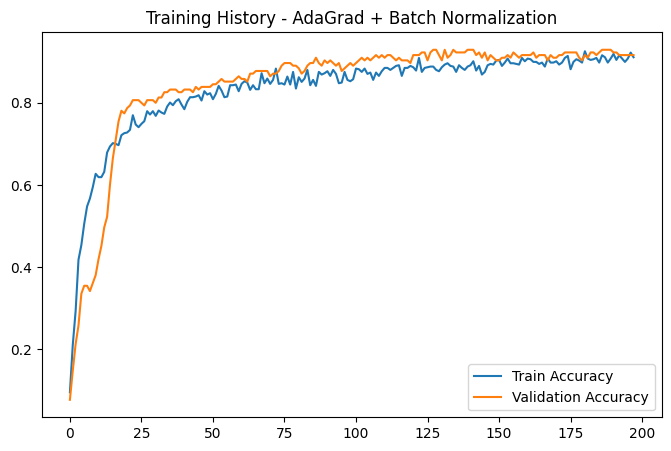

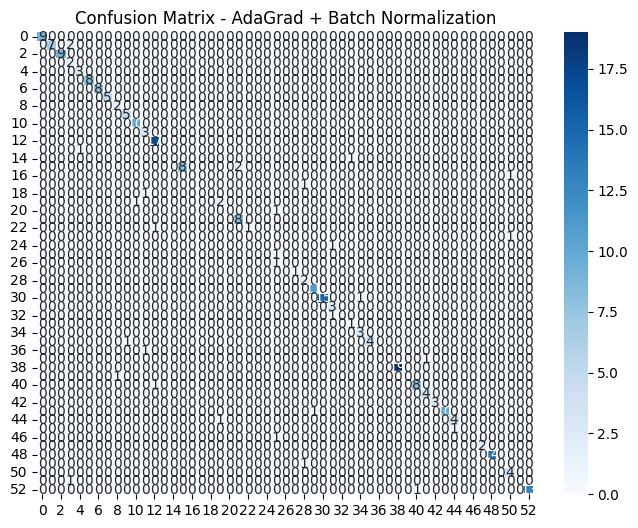

In [ ]:
from tensorflow.keras.layers import BatchNormalization # Importing BatchNormalization from tensorflow.keras.layers
from tensorflow.keras.optimizers import Adagrad # Importing Adagrad optimizer

# Model 6: AdaGrad + Batch Normalization
adagrad_bn_model = Sequential([
    Dense(64, activation='relu'),
    BatchNormalization(), # Now BatchNormalization should be recognized
    Dropout(0.2),
    Dense(48, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(len(np.unique(y)), activation='softmax')
])

# Now compile the model with the imported Adagrad optimizer
adagrad_bn_model.compile(optimizer=Adagrad(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_adagrad = adagrad_bn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0,
                                       callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])
adagrad_bn_metrics = evaluate_model(adagrad_bn_model, X_test, y_test, "AdaGrad + Batch Normalization", history_adagrad)